Percorsi impostati ✅


/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GT validi: 27551, clip: 8230, classi: 58


eval:  25%|██▍       | 2055/8230 [00:24<01:14, 82.47file/s] /var/folders/93/qz6yv96d61jg9b5h0sp47v_00000gn/T/ipykernel_23127/1199132789.py:143: RuntimeWarning: Mean of empty slice.
  e = mel[a:b].mean()
/opt/homebrew/Cellar/micromamba/2.0.8/envs/bmwTeam/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
eval: 100%|██████████| 8230/8230 [01:40<00:00, 81.71file/s] 


✓ Salvato results.csv
Macro-F1  : 0.4509
Micro-F1  : 0.4425
Micro-P   : 0.4663
Micro-R   : 0.4210



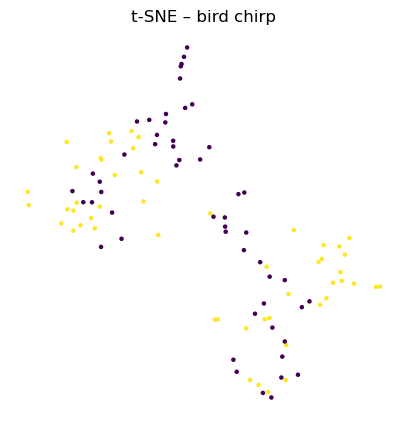

In [1]:
# %% 0 – CONFIG     
from pathlib import Path
from scipy.special import expit              
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

ANN_PATH   = Path("annotations.csv")     # ground‑truth
META_PATH  = Path("metadata.csv")        # start_time_s / end_time_s
LABEL_DIR  = Path("labels")              # *.npz con prediction LF
FEAT_DIR   = Path("audio_features")      # *.npz con melspectrogram
OUT_DIR    = Path("eval_out")            # dove salvare i risultati

SR_DEFAULT   = 32_000     # sample‑rate se mancante
HOP_DEFAULT  = 512        # hop_length se mancante
IOU_GT_RATIO = 0.3        # minimo 30 % del GT coperto → TP
MERGE_GAP    = 0.30       # unisci segmenti LF con gap < 300 ms
ENERGY_DB_TH = -50.0      # soglia dB per dire «udibile»

ENERGY_USE_WAV = False   # False = usa mel-spectrogram, True = ricarica .mp3
MI_N_FRAMES    = 15_000  # campioni max/usati per Mutual-Information

OUT_DIR.mkdir(exist_ok=True)
print("Percorsi impostati ✅")

# %% 1 – IMPORT STANDARD
import ast, json, math, itertools
from collections import defaultdict

import numpy as np
import pandas as pd
from intervaltree import Interval, IntervalTree
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# %% 2 – CARICA ANNOTAZIONI + METADATA, NORMALIZZA
ann = pd.read_csv(ANN_PATH)
ann["categories"] = ann["categories"].apply(ast.literal_eval)
ann["categories"] = ann["categories"].apply(lambda L: [c.lower().strip() for c in L])

if META_PATH.exists():
    meta = pd.read_csv(META_PATH, usecols=["filename", "start_time_s", "end_time_s"])
    ann = ann.merge(meta, on="filename", how="left")
    ann["onset"]  = ann["onset"]  - ann["start_time_s"].fillna(0)
    ann["offset"] = ann["offset"] - ann["start_time_s"].fillna(0)
else:
    ann["start_time_s"] = 0.0

# rimuovi intervalli nulli / negativi
ann = ann[ann["onset"] < ann["offset"]]
ann["idx"] = ann["filename"].str.replace(".mp3", "", regex=False)

CLASSES = sorted({c for cats in ann["categories"] for c in cats})
print(f"GT validi: {len(ann)}, clip: {ann['idx'].nunique()}, classi: {len(CLASSES)}")

# %% 3 – HELPER FUNZIONI

def covers_gt(pred, gt, thr=IOU_GT_RATIO):
    inter = max(0, min(pred[1], gt[1]) - max(pred[0], gt[0]))
    return inter / (gt[1]-gt[0]) >= thr


def merge_segments(segs, gap=MERGE_GAP):
    """segs = list[(start,end)] già ordinati; merge se gap<gap"""
    if not segs:
        return []
    merged = [list(segs[0])]
    for a, b in segs[1:]:
        if a - merged[-1][1] <= gap:
            merged[-1][1] = max(merged[-1][1], b)
        else:
            merged.append([a, b])
    return [tuple(s) for s in merged]


def frames_to_segments(mask: np.ndarray, sr: int, hop: int):
    """Convert a 1‑D binary/probability mask (per frame) into (start,end) segments in **seconds**."""
    onsets = np.where(mask[:-1] <= 0)[0] + 1  # start after zero→nonzero
    onsets = np.insert(onsets, 0, 0) if mask[0] > 0 else onsets
    offsets = np.where(mask[1:] <= 0)[0] + 1  # first zero after nonzero
    offsets = np.append(offsets, len(mask)) if mask[-1] > 0 else offsets
    return [(o * hop / sr, off * hop / sr) for o, off in zip(onsets, offsets) if off > o]


def load_pred_segments(path, clip_len, start_shift=0.0, sr=SR_DEFAULT, hop=HOP_DEFAULT):
    """
    Restituisce (segments, class) già:
      • convertiti in secondi (se erano frame)
      • traslati di -start_shift (clip‑relativi)
      • filtrati fuori dal range [0, clip_len]
      • uniti con gap < MERGE_GAP
    """
    data = np.load(path, allow_pickle=True)
    segs_by_cat = defaultdict(list)

    for cls in data.files:
        arr = np.asarray(data[cls], dtype=float)
        cls_norm = cls.strip().lower()

                # ───────── decodifica formato ─────────
        if arr.ndim == 2 and arr.shape[1] in {2,3}:   # (N,2) o (N,3)
            if arr.shape[1] == 3:                     # probabilità per frame
                mask = arr[:, 0]                      # usa primo canale p(event)
                if mask.max() <= 0:
                    continue
                cand = frames_to_segments(mask, sr, hop)
            else:                                     # (N,2)
                is_frame = arr.max() > clip_len * 10
                cand = [(tuple(s * hop / sr) if is_frame else tuple(s)) for s in arr]

            for seg in cand:
                seg = (seg[0] - start_shift, seg[1] - start_shift)
                if seg[1] <= 0 or seg[0] >= clip_len:
                    continue
                segs_by_cat[cls_norm].append(seg)

        elif arr.ndim in {1, 2} and arr.shape[-1] == 1:  # mask per frame (N,1) o (N,)
            mask = arr.squeeze()
            if mask.max() <= 0:
                continue
            for seg in frames_to_segments(mask, sr, hop):
                seg = (seg[0] - start_shift, seg[1] - start_shift)
                if seg[1] <= 0 or seg[0] >= clip_len:
                    continue
                segs_by_cat[cls_norm].append(seg)
        else:
            print("⚠️ forma non gestita:", cls, arr.shape)
            print("⚠️ forma non gestita:", cls, arr.shape)

    # merge + restituisci
    segs_final, cats_final = [], []
    for cat, lst in segs_by_cat.items():
        lst.sort()
        for m in merge_segments(lst):
            segs_final.append(m); cats_final.append(cat)
    return segs_final, cats_final


# ——— energia in dB di un segmento ———
def segment_energy_db(mel, seg, hop, sr):
    a,b = int(seg[0]*sr/hop), int(seg[1]*sr/hop)
    # mel: (T, F) log-magnitude;  potenza media → dB
    e = mel[a:b].mean()
    return 10*np.log10(max(e, 1e-12))

# ——— ricava MFCC+ZCR frame-positivi/negativi per MI ———
def collect_features_for_mi(feat, lbl_mask, max_n=MI_N_FRAMES):
    X = np.hstack([feat['mfcc'], feat['zerocrossingrate']])
    y = lbl_mask.astype(int)
    # bilancia le classi e sottocampiona
    pos_idx = np.where(y==1)[0]
    neg_idx = np.where(y==0)[0]
    n = min(max_n//2, len(pos_idx), len(neg_idx))
    keep = np.concatenate([np.random.choice(pos_idx,n,False),
                           np.random.choice(neg_idx,n,False)])
    return X[keep], y[keep]


# ------------------------------------------------------------------------------------------------------------------------

# %% 4 – LOOP DI VALUTAZIONE
# stats = {c: dict(TP=0, FP=0, FN=0) for c in CLASSES}
stats = {c: dict(TP=0, FP=0, FN=0,
                 TP_aud=0, TP_sil=0,
                 FN_aud=0, FN_sil=0) for c in CLASSES}
mi_store = {c: [] for c in CLASSES}     # raccolta feature→MI


groups = ann.groupby("idx")
for idx, gt_rows in tqdm(groups, desc="eval", unit="file"):
    start_sec = float(gt_rows["start_time_s"].iloc[0])


    feat_path = FEAT_DIR / f"{idx}.npz"
    if not feat_path.exists():
        continue  
    feat = np.load(feat_path, allow_pickle=True)

    hop = int(feat.get("hop_length", HOP_DEFAULT))
    sr  = int(feat.get("sample_rate",  SR_DEFAULT))
    n_frames = feat["melspectrogram"].shape[0]
    clip_len = n_frames * hop / sr
    tree = defaultdict(IntervalTree)

    mel = feat['melspectrogram']   # shape (T, F)

    segs_pred, cats_pred = load_pred_segments(
        LABEL_DIR / f"{idx}_labels.npz",
        clip_len=clip_len,
        start_shift=start_sec,
        sr=sr, hop=hop,
    )

    wav_energy = {}     # (begin,end) -> audible?
    for r in gt_rows.itertuples():
        for cat in r.categories:
            a,b = max(0,r.onset), max(0,r.offset)
            if b<=a or a>=clip_len: continue
            aud = segment_energy_db(mel,(a,b),hop,sr) > ENERGY_DB_TH
            tree[cat].add(Interval(a,min(b,clip_len),{"aud":aud}))
            wav_energy[(a,b,cat)] = aud


    matched = {c: set() for c in CLASSES}

    for cat in CLASSES:
    
        mask = np.zeros(n_frames, dtype=bool)
        for iv in tree.get(cat, []):
            a,b = int(iv.begin*sr/hop), int(iv.end*sr/hop)
            mask[a:b] = True
        if mask.any():
            X, y = collect_features_for_mi(feat, mask)
            mi_store[cat].append((X,y))

    for seg, cat in zip(segs_pred, cats_pred):
        if cat not in stats:
            continue
        overlaps = [iv for iv in tree[cat].overlap(*seg) if covers_gt(seg, (iv.begin, iv.end))]
        if overlaps:
            aud_gt = overlaps[0].data['aud']
            key = "TP_aud" if aud_gt else "TP_sil"
            stats[cat][key] += 1
            stats[cat]["TP"] += 1                
            matched[cat].add((overlaps[0].begin, overlaps[0].end))
        else:
            stats[cat]["FP"] += 1



    for cat,tr in tree.items():
        for iv in tr:
            if (iv.begin,iv.end) not in matched[cat]:
                k = "FN_aud" if iv.data['aud'] else "FN_sil"
                stats[cat][k] += 1
                stats[cat]["FN"] += 1


# %% 5 – BUILD METRICS DF – BUILD METRICS DF
rows = []
for cat,s in stats.items():
    tp,fp,fn = s["TP"],s["FP"],s["FN"]
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    rows.append({**{"class":cat,"precision":prec,"recall":rec,"f1":f1}, **s})
df = pd.DataFrame(rows).sort_values("class")
df.to_csv(OUT_DIR/"results.csv", index=False)
print("✓ Salvato results.csv")

# Mutual-Information feature ranking
mi_rows = []
for cat,pairs in mi_store.items():
    if not pairs: continue
    X = np.vstack([p[0] for p in pairs])
    y = np.hstack([p[1] for p in pairs])
    X = StandardScaler().fit_transform(X)
    mi = mutual_info_classif(X, y, random_state=0)
    for k,val in enumerate(mi):
        mi_rows.append({"class":cat, "feat_idx":k, "MI":val})
pd.DataFrame(mi_rows).to_csv(OUT_DIR/"mutual_info.csv", index=False)


# %% 6 – AGGREGATI
macro_f1 = df["f1"].mean()
micro_tp = df.TP.sum(); micro_fp = df.FP.sum(); micro_fn = df.FN.sum()
micro_p = micro_tp/(micro_tp+micro_fp+1e-9)
micro_r = micro_tp/(micro_tp+micro_fn+1e-9)
micro_f1 = 2*micro_p*micro_r/(micro_p+micro_r+1e-9)

with open(OUT_DIR/"overall_metrics.txt","w") as f:
    f.write(f"Macro-F1  : {macro_f1:.4f}\n");
    f.write(f"Micro-F1  : {micro_f1:.4f}\n");
    f.write(f"Micro-P   : {micro_p:.4f}\n");
    f.write(f"Micro-R   : {micro_r:.4f}\n");
print((OUT_DIR/"overall_metrics.txt").read_text())


# %% t-SNE Visual qualitativa
sample_cls = 'bird chirp'      
pairs = mi_store[sample_cls]
if pairs:
    X,y = pairs[0]       
    emb = TSNE(perplexity=30,random_state=0).fit_transform(X[:2000])
    plt.figure(figsize=(5,5))
    plt.scatter(emb[:,0], emb[:,1], c=y[:2000], s=5)
    plt.title(f"t-SNE – {sample_cls}")
    plt.axis('off'); plt.show()



In [2]:
# Mutual-Information feature ranking
mi_rows = []
clustering_rows = []   # 👈 nuovo: raccoglie silhouette e DB index

for cat,pairs in mi_store.items():
    if not pairs: continue
    X = np.vstack([p[0] for p in pairs])
    y = np.hstack([p[1] for p in pairs])
    X = StandardScaler().fit_transform(X)
    mi = mutual_info_classif(X, y, random_state=0)
    for k,val in enumerate(mi):
        mi_rows.append({"class":cat, "feat_idx":k, "MI":val})

    # 👇 valutazione clustering quantitativa
    from sklearn.metrics import silhouette_score, davies_bouldin_score
    try:
        silhouette = silhouette_score(X, y)
        db_index = davies_bouldin_score(X, y)
    except Exception:
        silhouette, db_index = float("nan"), float("nan")
    clustering_rows.append({"class": cat, "silhouette": silhouette, "davies_bouldin": db_index})

# salva tutto
pd.DataFrame(mi_rows).to_csv(OUT_DIR/"mutual_info.csv", index=False)
pd.DataFrame(clustering_rows).to_csv(OUT_DIR/"clustering_metrics.csv", index=False)
print("✓ Salvati MI e metriche clustering")


✓ Salvati MI e metriche clustering


In [3]:
print("Top clustering results (by Silhouette):")
top_results = sorted(clustering_rows, key=lambda x: x["silhouette"], reverse=True)[:5]
for res in top_results:
    print(f"Classe: {res['class']}, Silhouette: {res['silhouette']:.3f}, Davies-Bouldin: {res['davies_bouldin']:.3f}")


Top clustering results (by Silhouette):
Classe: cow moo, Silhouette: 0.008, Davies-Bouldin: 10.244
Classe: sewing machine, Silhouette: 0.007, Davies-Bouldin: 10.797
Classe: saxophone, Silhouette: 0.006, Davies-Bouldin: 14.075
Classe: fire, Silhouette: 0.006, Davies-Bouldin: 12.189
Classe: hiccup, Silhouette: 0.006, Davies-Bouldin: 8.142
